# Style Transfer with Backpropogation Through a Convolutional Neural Network

### Can we extarct and apply the abstractions learned by a deep neural network?

## Description

---

In this notebook I recreate a style transfer method outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

This is a realitivly slow method of style transfer; I will be exploring faster methods after this one!

Some questions that inevitably pop up when thinking about how to transfer the style from one image to the content of another image are, 
- How dow you quantify 'style'?
- How do you separate that style from an image's 'content'?
- How do you apply that 'style' to another image's 'content'?

## Methods

---

The paper mentioned above explores the idea that content representations reside in higher layers in a trained convolutuional neural network (CNN) and style representations reside in lower levels in a trained CNN.

This makes intuitive sense as lower levels of a CNN learn to identify simple shapes, colors, edges, and so on while higher levels combime these simple features into more complex features (e.g. eyes, faces, dogs, houses, etc.) These complex features can be used to represent the content of an image while the lower level features can be used to represent style (e.g. colors, brushstrokes, motifs, etc.)

Specifically mentined in the paper, 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', and 'conv5_1' layers are used for style representation and 'conv4_2' is used for content representation


However, there is a bit more to 'style' that the paper explores. Style can be further described as low level features that are activated consistently together between the filter maps of a single low level layer in a CNN. In this way the 'style' of an image can be represented numerically by creating a gram matrix of a low level layer activations of a trianed CNN as an image is fed forward through it.

With these pieces defined, we can create a loss function that takes into account how different a target tensor's style is from a style image's, and how different a target tensor's content is from a content image's

Using this loss we can backpropogate the error through a network which has had it's parameters frozen to update the target tensor wich represents the final image!

## Results

---

While this method creates some amazing looking results, it is unfortunately rather slow.

Because it relies on backpropogation, many iterations of calculating the loss and backpropogating the error need to be preformed to get a good looking result. The speed also depends on the size of the image and if you have access to a GPU

Experimenting with some hyperparameters I found that cranking the learning rate up had a positive effect on how fast the target image converged to a good looking result. Additionally, I found that increasing how significantly the lower 'style' layers contribute to the loss calculation caused a more dramatic style transfer that required fewer interations to converge on a good looking result. And lastly, resizing the target to be a smaller tensor has a big impact on how fast the style can be transfered.


In [538]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [539]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

#### Helpers

In [540]:
def load_image(img_path, max_size=300, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    size = max_size if max(image.size) > max_size else max(image.size)
  
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image



In [541]:
def im_convert(tensor):
    ''' Display a tensor as an image. 
    Undo normalization and convert to numpy array from a tensor '''
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image



In [542]:
def get_features(image, model):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  ## content representation
              '28': 'conv5_1'}
        
    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features


In [543]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    b, d, h, w = tensor.size()
    tensor = tensor.view(b * d, h * w)

    gram = torch.mm(tensor, tensor.t())    
    return gram 

In [544]:
def style_transfer(content, style, style_weights, alpha=1, beta=1e6, steps=500, lr=0.2):
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    target = content.clone().requires_grad_(True).to(device)
    optimizer = optim.Adam([target], lr=lr)

    for i in range(1, steps+1):
        target_features = get_features(target, vgg)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)
        total_loss = alpha * content_loss + beta * style_loss
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return target
  

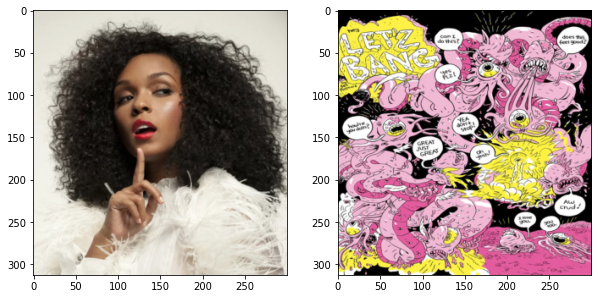

In [555]:

content = load_image('assets/janelle.png').to(device)
style = load_image('assets/ben_passmore.jpg', shape=content.shape[-2:]).to(device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
plt.show()

In [546]:

alpha = 1
beta = 1e6
style_weights = {'conv1_1': 5.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2,
                }

target = style_transfer(content, style, style_weights,
                          alpha=alpha, beta=beta)

## Display the Target Image

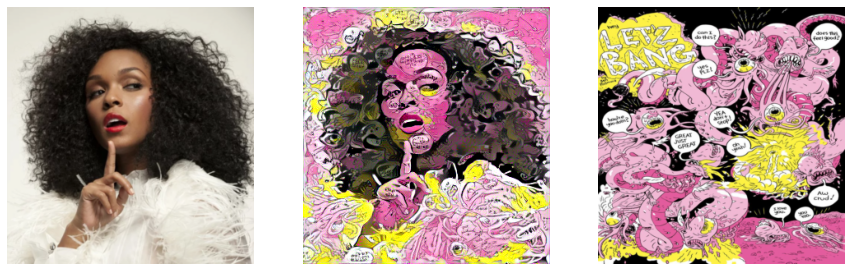

In [554]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
ax3.imshow(im_convert(style))
plt.show()